"""
Objective: 
1. Compuate 8 Features
    - 4 common features (mean, STD, area under the receiver operating characteristic curve (AUC) and slope)
    - four novel feature (CBV, COE, |L| and K) 

Input: Subject, Channel, TimeSamplePoint, HbType

Output: [TemporalFeatures, SpatialFeatures] 
    TemporalFeatures Subject x (Channel x TimeSample x FourNovelFeature) (52*125*4==26000)

Requirement: 
    index_start: datapoint of Acitvating-Task start
        For example: you have 1250 datapoint with the sampling rate of 10Hz. The task starts at 10s. So you index_start would be 100=10s*10Hz
    index_end: datapoint of Acitvating-Task end

Ref: Zhu, Yibo, et al. "Classifying major depressive disorder using fNIRS during motor rehabilitation." IEEE Transactions on Neural Systems and Rehabilitation Engineering 28.4 (2020): 961-969.
"""

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Choose
model_name = 'chao_cfnn' # modify me!!!!!!

hbo_main_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbO-All-Lowmid-High/correct_channel_data.npy'
hbr_main_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbR-All-Lowmid-High/correct_channel_data.npy'
feature_save_path = f'/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/data_for_reproducing_model/HbO-All-Lowmid-High/{model_name}'


def check_create_path(feature_save_path):
    import os
    if not os.path.exists(feature_save_path):
        print('Hello')
        os.makedirs(feature_save_path)
check_create_path(feature_save_path)
# hbo_main_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbO-All-HC-MDD/correct_channel_data.npy'
# hbr_main_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbR-All-HC-MDD/correct_channel_data.npy'


hbo_data = np.load(hbo_main_path)
hbo_data = np.transpose(hbo_data, (0,2,1))
hbr_data = np.load(hbr_main_path)
hbr_data = np.transpose(hbr_data, (0,2,1))


# input = np.random.rand(458, 52, 125)
# please make sure the input data is normalized using something like z-norm
def normalize(data):
    # Iterate over each subject
    normalized_data = np.empty_like(data)
    # Calculate the mean and standard deviation for the current subject
    mean = np.mean(data)
    std = np.std(data)

    # Perform z-normalization for the current subject
    normalized_data= (data - mean) / std
    return normalized_data


input = normalize(np.concatenate((hbo_data[...,np.newaxis],hbr_data[...,np.newaxis]),axis=3))

print(f' input shape -> {input.shape}')
index_start = 10
index_end = 70
hbo_type = 0
hbr_type = 1

Hello
 input shape -> (216, 52, 125, 2)


In [8]:
# First to extract the four common features (mean, STD, area under the receiver operating characteristic curve (AUC) and slope)
input_hbo_task_part = input[:,:,index_start: index_start+(index_end-index_start)//2, hbo_type] # used the first half of the task period 

def extract_mean(data):
    res = np.mean(data, axis=2)
    return res
feature_1 = extract_mean(input_hbo_task_part)

def extract_std(data):
    res = np.std(data, axis=2)
    return res
feature_2 = extract_std(input_hbo_task_part)

def extract_AUC(data):
    res = np.sum(data, axis=2)
    return res
feature_3 = extract_AUC(input_hbo_task_part)

def extract_slope(data):
    slopes = np.zeros((data.shape[0], data.shape[1]))  # To store the slopes
    # Calculating the slope for each (subject, channel) pair across timepoints
    for i in range(data.shape[0]):  # Loop through subjects
        for j in range(data.shape[1]):  # Loop through channels
            # np.polyfit returns coefficients of the polynomial, highest power first
            # Since we're fitting a line, we get two values: slope and intercept
            slope, intercept = np.polyfit(range(data.shape[2]), data[i, j, :], 1)
            slopes[i, j] = slope
    return slopes
feature_4 = extract_slope(input_hbo_task_part)

# CBV 
hbo = input[...,hbo_type]
hbr = input[...,hbo_type]
CBV = (hbo + hbr) / np.sqrt(2)
print(CBV.shape)

# COE 
COE = (hbo - hbr) / np.sqrt(2)
print(COE.shape)
# L 
Mag_L = np.sqrt((np.square(hbo) + np.square(hbr))) / np.sqrt(2)
print(Mag_L.shape)

# Angle K 
Ang_K = np.arctan(COE/CBV)
print(Ang_K.shape)

def reshape_to_matrix(data):
    reshape_data = np.reshape(data, (data.shape[0], data.shape[1]*data.shape[2]))
    return reshape_data
r_CBV = reshape_to_matrix(CBV) # (458, 6500)
r_COE = reshape_to_matrix(COE) # (458, 6500)
r_Mag_L = reshape_to_matrix(Mag_L) # (458, 6500)
r_Ang_K = reshape_to_matrix(Ang_K) # (458, 6500)
novel_features = np.concatenate((r_CBV, r_COE, r_Mag_L, r_Ang_K), axis=1) # (458, 26000)
np.save(feature_save_path + '/data', novel_features)

(216, 52, 125)
(216, 52, 125)
(216, 52, 125)
(216, 52, 125)


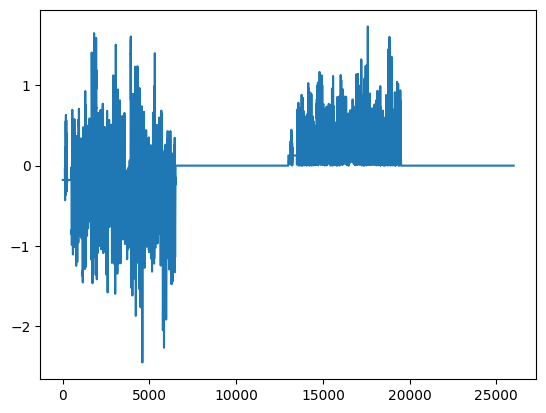

In [10]:
plt.plot(novel_features[0])

-0.12605460729656187
0.015876
[[[1.58897640e-02 1.58897640e-02 1.58897640e-02 ... 1.58897640e-02
   1.58897640e-02 1.58897640e-02]
  [2.91750415e-04 4.15228352e-03 8.35032384e-03 ... 1.73381710e-02
   2.18899683e-02 1.86139368e-02]
  [1.58897640e-02 1.58897640e-02 1.58897640e-02 ... 1.58897640e-02
   1.58897640e-02 1.58897640e-02]
  ...
  [7.97316183e-03 2.83957154e-03 2.49779967e-04 ... 2.26824431e-02
   1.08571186e-02 1.46215591e-03]
  [9.50383108e-03 7.99013204e-03 6.11223590e-03 ... 2.74947557e-02
   1.59776912e-02 3.12656295e-03]
  [1.22478524e-02 5.78592058e-03 1.00471394e-03 ... 2.84576881e-02
   1.16649630e-02 1.13869358e-04]]

 [[4.56274020e-03 1.11107960e-02 1.77010879e-02 ... 1.85618136e-02
   4.02742695e-02 2.35102905e-02]
  [9.68049607e-03 2.67068180e-03 3.84411057e-02 ... 1.74881403e-02
   4.56710231e-02 5.49649467e-02]
  [1.16979087e-01 8.78656497e-02 6.46015790e-02 ... 2.16099909e-02
   3.84445832e-02 4.13209126e-02]
  ...
  [2.31445638e-01 1.44664136e-01 4.85962740e-02